# Sarcasm detection model

Creating a model with the intention of detecting sarcasm in text by training a neural network deep learning model with a data set of sarcastic and non-sacrastic headlines from [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection). 

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import re
import json

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Data cleaning & pre-processing

#### Reading json file
Importing dataset version 2 by reading the json file and storing it into a dataframe.

In [5]:
data = pd.read_json(r"C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\data\news_headlines\Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [6]:
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


#### Changing / removing columns
As well as dropping column "article_link", since it does not contain any valuable information to train the sarcasm model with.  
This also saves time and computing power by lowering the amount of data that needs to be inspected by the model.

In [7]:
data = data.rename(columns = {"is_sarcastic":"Sarcasm","headline":"Headline"})

In [8]:
data = data.drop("article_link",axis=1)
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


#### Exploring the data
Checking out general info and null values in the data set.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sarcasm   28619 non-null  int64 
 1   Headline  28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [10]:
data.isnull().sum()

Sarcasm     0
Headline    0
dtype: int64

#### Visualizing Headlines
Creating a figure to show the sarcastic vs. non-sarcastic headlines.  
There are around 1000 more non-sarcastic headlines than sarcastic ones. 

In [11]:
data["Sarcasm"].value_counts()

0    14985
1    13634
Name: Sarcasm, dtype: int64

<AxesSubplot:title={'center':'Non-Sarcastic vs. Sarcastic'}, xlabel='Sarcasm', ylabel='count'>

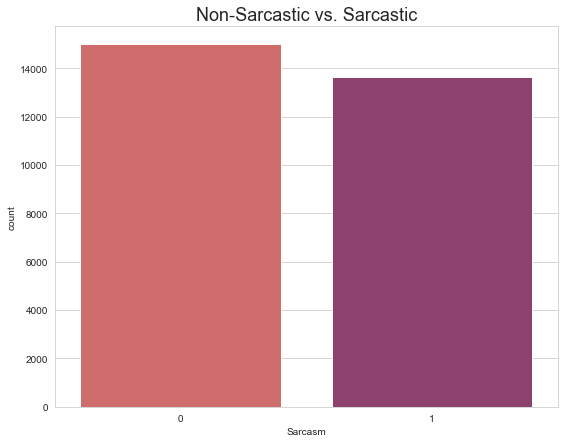

In [12]:
sns.set_style("whitegrid")

plt.figure(figsize = (9,7))

plt.title("Non-Sarcastic vs. Sarcastic", fontsize=18)
sns.countplot(x="Sarcasm",data=data, palette="flare")

In [13]:
plt.savefig(r"C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\your-project\sarcastic_headlines.png")

<Figure size 432x288 with 0 Axes>

#### Checking for duplicates
...in the column Headline. Below you can see that 116 rows of the dataframe contain duplicates.  
The question is if they are somehow logical and necessary or if they need to be cleaned.
- My thoughts: the model performs better without the training/test data containing duplicates

In [17]:
data.duplicated(subset=["Headline"]).value_counts()

False    28503
True       116
dtype: int64

List of duplicates that will be removed:

In [18]:
dupes = data[data.duplicated(subset=["Headline"])==True]
dupes.head()

,Sarcasm,Headline
1780,1,willow rented
3978,1,all y'all urged to go fuck yo' selves
4771,0,sunday roundup
4904,1,tammys of the world demand to be taken seriously
5092,0,the funniest tweets from parents this week


In [19]:
data = data.drop_duplicates(subset=["Headline"])

In [20]:
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


#### Exploring details in "Headline"
As you can see below, there are many special characters! I'm going to replace them with empty spaces " ".
Then I will also replace the abreviated words like you're and she's and turn them into you are and she is. This will make  
it easier for the model to work better. 

In [17]:
data[data["Headline"].str.contains("-")].head()

,Sarcasm,Headline
7,1,richard branson's global-warming donation near...
16,1,area boy enters jumping-and-touching-tops-of-d...
19,0,lin-manuel miranda would like to remind you to...
34,1,new york introduces shoe-sharing program for c...
40,0,the best clothes for the man-child in your life


In [18]:
data[data["Headline"].str.contains("/")].head()

,Sarcasm,Headline
384,0,if i have gay children: 4 promises from a chri...
821,1,google's 9/11 homepage design stirs controversy
1169,1,encouraging report from radical extremist thin...
1209,0,this is what it was like to go to the airport ...
1413,0,barack obama makes last-minute push to block s...


#### Removing special characters and changing abbreveations
...using a function partially retreived from this [Repo](https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/Sarcasm%20is%20very%20easy%20to%20detect%20GloVe%2BLSTM.ipynb)  
- This is sort of like stemming (changing a word of the same stem back to its stem, e.g. running > run)
- Remove special characters and replace them with nothing

In [21]:
def clean_text(text):
    text = text.lower()
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    
    return text

#### Test clean_text()
Testing the function on a single sentence:

In [22]:
headlines = data["Headline"].values.tolist()

In [23]:
clean_text(headlines[24])

'bill clinton shoots down republicans i strongly supported obamacare'

#### Applying clean_text() to Headlines

In [22]:
cleaned = []
for string in headlines:
    string = clean_text(string)
    cleaned.append(string) 

In [23]:
data["Headline"] = cleaned
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


#### Visualizing word clouds
One cloud each for the categories sarcastic and non-sarcastic.

In [24]:
data_cloud = data.copy()

In [25]:
sarcasm = data_cloud[data_cloud["Sarcasm"] == 1]

In [26]:
normal = data_cloud[data_cloud["Sarcasm"] == 0]

In [27]:
stopwords = set(STOPWORDS)

In [28]:
text1 = " ".join(line for line in sarcasm["Headline"])

In [29]:
#text1

In [30]:
#wordcloud1 = WordCloud(stopwords=stopwords, max_words=1000, background_color="white").generate(text1)

#wordcloud1 = WordCloud().generate(text1)

# Display the generated image the matplotlib way:
#plt.imshow(wordcloud1)
#plt.axis("off")
#plt.show()

In [31]:
text2 = " ".join(line for line in normal["Headline"])

In [32]:
#wordcloud2 = WordCloud(stopwords=stopwords, max_words=2000, background_color="white").generate(text2)

# Display the generated image the matplotlib way:
#plt.imshow(wordcloud2, interpolation='bilinear')
#plt.axis("off")
#plt.show()

In [33]:
#word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text1)
#ax = plt.figure(figsize=(15,10))
#plt.imshow(word_cloud, interpolation='bilinear')
#plt.axis("off")


#plt.savefig("../Figures/word_cloud_neutral.png",dpi=300)
#plt.show()

## Building the sarcasm model
The topics of this project were not part of the material I learned during the Ironhack bootcamp. Since there was a time limit on finishing this project, I was unable to attain a complete, detailed understanding about how to build these types of deep   learning models. However I was able to gain basic knowledge about natural language processing models using e.g. word embeddings.
Since I couldn't get any guidance on this project on the specific steps on how to build the sarcasm model, I created two models following along these approaches and the code from following resources:
- [Google Developers](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb#scrollTo=LoBXVffknldU)
- [this Repo](https://github.com/Harshita9511/Sarcasm-Detection-with-Neural-Networks/blob/master/Sarcasm_Detection_with_Neural_Networks.ipynb)

Creating lists made of the columns "Sarcasm" and "Headline"

In [34]:
sarcasm = list(data["Sarcasm"].values)
headlines = list(data["Headline"].values)

#### Setting parameters
There are several parameters that can be used in the model. Here I'm also setting parameters for tokenization, padding and splitting the dataset:

In [35]:
vocab_size = 7500
embedding_dim = 16
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

The size of the list containing headlines is ~28.000. I'm using 23.000 values for the training and 8.000 for testing

In [ ]:
training_size = 23000

#### Splitting data for model training
I'm not using the train test split function, since I created lists which will now serve as X and y values.  
In this sense, X is the headlines and y is the sarcasm label.  
- X_train = headlines - (test-headlines)  
- y_train = sarcasm - test-sarcasm  
- X_test = test-headlines  
- y_test = test-sarcasm   

In [36]:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]

training_sarcasm = sarcasm[0:training_size]
testing_sarcasm = sarcasm[training_size:]

In [68]:
training_headlines

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly',
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 'richard bransons globalwarming donation nearly as much as cost of failed balloon trips',
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana and an amazing one at that',
 'amanda peet told her daughter sex is a special hug',
 'what to know regarding current treatments for ebola',
 'chris christie suggests hillary clinton was to blame for boko harams kidnapping of hundreds of schoolgirls',
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick stepping down fr

### Tokenization & padding
The words of each sentence in the list "headlines" are tokenized using TensorFlow. Each word is turned into a vector containing  information about the meaning of the word (e.g. "not bad" isn't good, but not bad either). The higher the number of the word, the lower the frequency of occurrence of the word in the data set.   
Padding is done to make sure that all sentences (which are now sequences of numbers/vectors) have the same lenght. This is done to create optimal conditions for the model to be able to learn properly what it should learn - detecting sarcasm.

In [37]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Model with word embedding
Every word is embedded, which means it will be transformed into a vector containing information about the words..   
- Further [info](https://machinelearningmastery.com/what-are-word-embeddings/)  
  
Turning the data into arrays (because TensorFlow needs an array as input)

In [38]:
training_padded = np.array(training_padded)
training_sarcasm = np.array(training_sarcasm)
testing_padded = np.array(testing_padded)
testing_sarcasm = np.array(testing_sarcasm)

#### Model 1

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#### Model 2

In [40]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(Flatten())

model1.add(Dense(units=32,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=10,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#### Model 3

In [41]:
vocab_lenght = ((len(word_index)) + 1)

In [61]:
#sequence_lenght = training_headlines.shape[1]

In [ ]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model6.summary())

#### Model summaries
Showing the layers, type of layer and its parameters.

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 16)            120000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 28)                476       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 29        
Total params: 120,505
Trainable params: 120,505
Non-trainable params: 0
_________________________________________________________________


In [43]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 16)            120000    
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                20512     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Model training
Training the models, value loss and accuracy can be seen for training and test data.
#### Model 1

In [44]:
history = model.fit(training_padded, training_sarcasm, epochs=30, validation_data=(testing_padded, testing_sarcasm), verbose=2)

Epoch 1/30
719/719 - 1s - loss: 0.5472 - accuracy: 0.7210 - val_loss: 0.3906 - val_accuracy: 0.8299
Epoch 2/30
719/719 - 1s - loss: 0.3237 - accuracy: 0.8668 - val_loss: 0.3484 - val_accuracy: 0.8490
Epoch 3/30
719/719 - 1s - loss: 0.2609 - accuracy: 0.8953 - val_loss: 0.3511 - val_accuracy: 0.8495
Epoch 4/30
719/719 - 1s - loss: 0.2247 - accuracy: 0.9124 - val_loss: 0.3595 - val_accuracy: 0.8475
Epoch 5/30
719/719 - 1s - loss: 0.2009 - accuracy: 0.9240 - val_loss: 0.3829 - val_accuracy: 0.8415
Epoch 6/30
719/719 - 1s - loss: 0.1810 - accuracy: 0.9333 - val_loss: 0.4109 - val_accuracy: 0.8346
Epoch 7/30
719/719 - 1s - loss: 0.1666 - accuracy: 0.9383 - val_loss: 0.4302 - val_accuracy: 0.8321
Epoch 8/30
719/719 - 1s - loss: 0.1556 - accuracy: 0.9417 - val_loss: 0.4703 - val_accuracy: 0.8288
Epoch 9/30
719/719 - 1s - loss: 0.1457 - accuracy: 0.9467 - val_loss: 0.4904 - val_accuracy: 0.8263
Epoch 10/30
719/719 - 1s - loss: 0.1364 - accuracy: 0.9507 - val_loss: 0.5110 - val_accuracy: 0.8246

#### Model 2

In [45]:
history = model1.fit(training_padded, training_sarcasm, epochs=30, validation_data=(testing_padded, testing_sarcasm), verbose=2)

Epoch 1/30
719/719 - 2s - loss: 0.6895 - accuracy: 0.5255 - val_loss: 0.6816 - val_accuracy: 0.5361
Epoch 2/30
719/719 - 1s - loss: 0.6596 - accuracy: 0.6005 - val_loss: 0.6046 - val_accuracy: 0.7281
Epoch 3/30
719/719 - 1s - loss: 0.5624 - accuracy: 0.7323 - val_loss: 0.4770 - val_accuracy: 0.8214
Epoch 4/30
719/719 - 1s - loss: 0.4682 - accuracy: 0.8091 - val_loss: 0.4125 - val_accuracy: 0.8381
Epoch 5/30
719/719 - 1s - loss: 0.4035 - accuracy: 0.8501 - val_loss: 0.3746 - val_accuracy: 0.8475
Epoch 6/30
719/719 - 1s - loss: 0.3610 - accuracy: 0.8749 - val_loss: 0.3578 - val_accuracy: 0.8526
Epoch 7/30
719/719 - 1s - loss: 0.3226 - accuracy: 0.8909 - val_loss: 0.3465 - val_accuracy: 0.8530
Epoch 8/30
719/719 - 1s - loss: 0.2968 - accuracy: 0.9062 - val_loss: 0.3371 - val_accuracy: 0.8574
Epoch 9/30
719/719 - 1s - loss: 0.2658 - accuracy: 0.9183 - val_loss: 0.3344 - val_accuracy: 0.8583
Epoch 10/30
719/719 - 1s - loss: 0.2413 - accuracy: 0.9289 - val_loss: 0.3361 - val_accuracy: 0.8599

### Visualize training 
...by plotting the accuracy and value loss in the training and testing data.
- [Source code](https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/Sarcasm%20is%20very%20easy%20to%20detect%20GloVe%2BLSTM.ipynb)

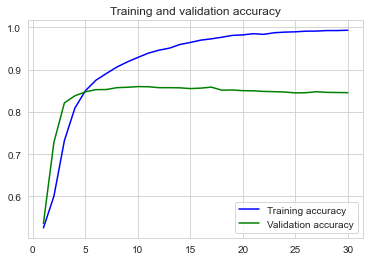

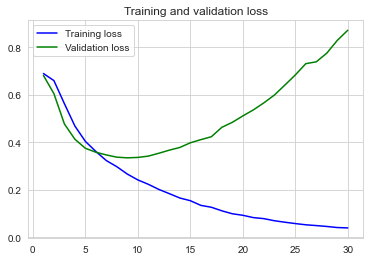

In [47]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [64]:
model.save(r"C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models")

INFO:tensorflow:Assets written to: C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models\assets


2021-07-29 22:22:08.108 Assets written to: C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models\assets


In [65]:
model1.save(r"C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models\Model2")

INFO:tensorflow:Assets written to: C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models\Model2\assets


2021-07-29 22:24:00.729 Assets written to: C:\Users\kim.buchner\Desktop\Ironhack\Module1\WEEK8\Project5\Project5\models\Model2\assets


### User input sarcasm detection
Creating a user input, so that a person can enter a sentence and my model will then claim the sentence as either:  
- sarcastic
- non-sarcastic

##### Model 1

In [50]:
sentence1 = ["It's raining, what a sunny day"]
sentence = ["granny starting to fear spiders in the garden might be real"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.9994134]]


##### Model 2

In [49]:
sentence1 = ["It's raining, what a sunny day"]
sentence = ["granny starting to fear spiders in the garden might be real"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model1.predict(padded))

[[0.5066933]]


##### Adding user input
[Source](https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/Sarcasm%20is%20very%20easy%20to%20detect%20GloVe%2BLSTM.ipynb)

In [51]:
user_input = input("Enter a sentence: ")
user_input = [user_input]

sequences = tokenizer.texts_to_sequences(user_input)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

Enter a sentence: granny starting to fear spiders in the garden might be real
[[0.9994134]]


In [52]:
def predict_sarcasm():
    user_input = input("Enter a sentence: ")

    user_input = [user_input]

    sequence = tokenizer.texts_to_sequences(user_input)
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    pred = model.predict(padded)

    if pred[0][0]>=0.5:
        print("This sentence is sarcastic!")
    else:
        print("This sentence is not sarcastic!")

In [53]:
predict_sarcasm()

Enter a sentence: granny starting to fear spiders in the garden might be real
This sentence is sarcastic!
